# REMCMC benchmark

エネルギーが
$$f(x)=\frac12\sum_{i=1}^d (x_i^4-16x_i^2+0.2x_i)$$
の関数(["STYBLINSKI-TANG FUNCTION"](https://www.sfu.ca/~ssurjano/stybtang.html)を改変したもの)のサンプリング  
すなわち確率分布
$$p(x)=\frac{\exp[-f(x)]}{\int \exp[-f(x)] dx} $$
のサンプリング．

大域最小解は
$$f(x^*)=-32.283d,\; \text{at}\; x^*=(-2.831,\dots,-2.831)$$
$\{-2.831, 2.825\}^d$の複数地点で極小値があり，さらに最小ではない極小値とエネルギー差が小さいため，局所最適化では大域解を求めづらい関数．  


$d=3$次元でテスト．
```bash
$ python remcmc_bench.py > sampling_log.txt
```
で通常のM-HアルゴリズムとReplica Exchangeでのサンプリング結果を`test_mhmcmc_*.bin`と`test_remcmc_*.bin`に保存．

In [1]:
import pickle
import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

真の関数形

In [2]:
import sys
sys.path.append('../../lib/')
from utils import multimodal_function

In [3]:
def f(X):
    Z = 7.32166*10**13
    return np.array([np.exp(- multimodal_function(np.array([x])))/Z for x in X])

In [4]:
global_solution=-2.83155

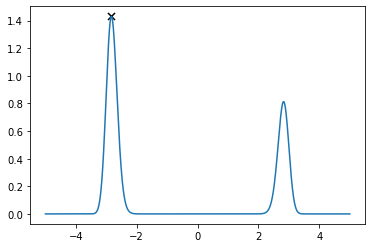

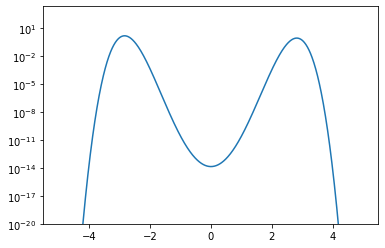

In [5]:
X = np.linspace(-5, 5, 1000)
Y = f(X)
plt.plot(
    X, Y
)
plt.scatter(
    [global_solution], [f([global_solution])],
    c="k", marker="x", s=50
)
#plt.yscale('log')
plt.show()

plt.plot(
    X, Y
)
plt.yscale('log')
plt.ylim(1e-20,)
plt.show()

$x<0$ と $x>0$ のピークの面積比は $0.636978: 0.363022$

この関数を3次元化した確率分布をサンプリングする

## M-Hアルゴリズム

初期値は $\mathcal{N}(0,10^2)$ でランダムに取る．

In [6]:
# 読み込み
data_s = []
for file_name in glob.glob("test_mhmcmc_*.bin"):
    with open(file_name, mode="rb") as file:
        data_s += [pickle.load(file)]

n_chain = len(data_s)
sample_j_n_k_c = np.array([data_s[chain]["sample_j_n_k"] for chain in range(n_chain)])

burnin = 5000
skip = 3

chainごとに得られた確率分布(1次元目)


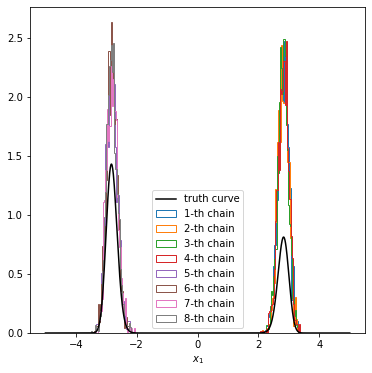

In [7]:
print("chainごとに得られた確率分布(1次元目)")
plt.figure(figsize=(6,6))
for chain in range(n_chain):
    plt.hist(
        sample_j_n_k_c[chain, 0, burnin::skip, 0],
        bins="auto", density=True, histtype="step",
        label=f"{chain+1}-th chain"
    )
plt.plot(
    np.linspace(-5, 5, 1000),
    f(np.linspace(-5,5,1000)),
    color="k", label="truth curve"
)
plt.legend()
plt.xlabel(r"$x_1$")
plt.show()

全chainで得られた確率分布(各次元)


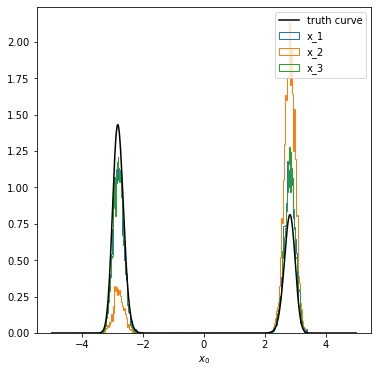

In [8]:
print("全chainで得られた確率分布(各次元)")
plt.figure(figsize=(6,6))
for d in range(3):
    plt.hist(
        np.concatenate([sample_j_n_k_c[chain, 0, burnin::skip, d] for chain in range(n_chain)]),
        bins=250, density=True, histtype="step",
        label=f"x_{d+1}"
    )
plt.plot(
    np.linspace(-5, 5, 1000),
    f(np.linspace(-5,5,1000)),
    color="k", label="truth curve"
)
plt.legend()
plt.xlabel(r"$x_0$")
plt.show()

大域的にサンプリングできていないと，初期値を変えて複数サンプリングを行ったとしても正しい確率分布は得られない

In [9]:
print("chainごとの左右のピークの面積比")
print(" "*5, "x_1<0 : x_1>0, x_2<0 : x_2>0, x_3<0 : x_3>0")
for chain in range(n_chain):
    print(f"{chain+1}-th:",
          "{:.3f}".format((sample_j_n_k_c[chain, 0, burnin::skip, 0]<0).mean()),":",
          "{:.3f},".format((sample_j_n_k_c[chain, 0, burnin::skip, 0]>0).mean()),
          "{:.3f}".format((sample_j_n_k_c[chain, 0, burnin::skip, 0]<1).mean()),":",
          "{:.3f},".format((sample_j_n_k_c[chain, 0, burnin::skip, 0]>1).mean()),
          "{:.3f}".format((sample_j_n_k_c[chain, 0, burnin::skip, 0]<2).mean()),":",
          "{:.3f}".format((sample_j_n_k_c[chain, 0, burnin::skip, 0]>2).mean()),)

chainごとの左右のピークの面積比
      x_1<0 : x_1>0, x_2<0 : x_2>0, x_3<0 : x_3>0
1-th: 0.000 : 1.000, 0.000 : 1.000, 0.000 : 1.000
2-th: 0.000 : 1.000, 0.000 : 1.000, 0.000 : 1.000
3-th: 0.000 : 1.000, 0.000 : 1.000, 0.000 : 1.000
4-th: 0.000 : 1.000, 0.000 : 1.000, 0.000 : 1.000
5-th: 1.000 : 0.000, 1.000 : 0.000, 1.000 : 0.000
6-th: 1.000 : 0.000, 1.000 : 0.000, 1.000 : 0.000
7-th: 1.000 : 0.000, 1.000 : 0.000, 1.000 : 0.000
8-th: 1.000 : 0.000, 1.000 : 0.000, 1.000 : 0.000


すべて片側に偏ってしまっている

In [10]:
print("全chainでの左右のピークの面積比")
print("x_1<0 : x_1>0, x_2<0 : x_2>0, x_3<0 : x_3>0")
print(
    "{:.3f}".format((np.concatenate([sample_j_n_k_c[chain, 0, burnin::skip, 0] for chain in range(n_chain)])<0).mean()), ":",
    "{:.3f},".format((np.concatenate([sample_j_n_k_c[chain, 0, burnin::skip, 0] for chain in range(n_chain)])>0).mean()),
    "{:.3f}".format((np.concatenate([sample_j_n_k_c[chain, 0, burnin::skip, 1] for chain in range(n_chain)])<0).mean()), ":",
    "{:.3f},".format((np.concatenate([sample_j_n_k_c[chain, 0, burnin::skip, 2] for chain in range(n_chain)])>0).mean()),
    "{:.3f}".format((np.concatenate([sample_j_n_k_c[chain, 0, burnin::skip, 1] for chain in range(n_chain)])<0).mean()), ":",
    "{:.3f}".format((np.concatenate([sample_j_n_k_c[chain, 0, burnin::skip, 1] for chain in range(n_chain)])>0).mean()),)

全chainでの左右のピークの面積比
x_1<0 : x_1>0, x_2<0 : x_2>0, x_3<0 : x_3>0
0.500 : 0.500, 0.125 : 0.500, 0.125 : 0.875


chainごとのサンプリング結果(1,2次元目)


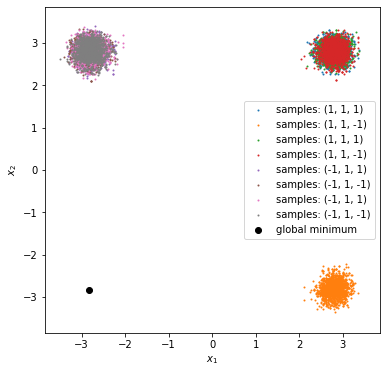

In [11]:
print("chainごとのサンプリング結果(1,2次元目)")
plt.figure(figsize=(6,6))
for chain in range(n_chain):
    i = chain
    plt.scatter(
        sample_j_n_k_c[chain, 0, burnin::skip, 0],
        sample_j_n_k_c[chain, 0, burnin::skip, 1],
        s=1, alpha=1, label=f"samples: {(-1)**(i//4),(-1)**((i//4)//2),(-1)**(i%2)}"
    )
plt.scatter([global_solution], [global_solution], c="k", label="global minimum")
lim = abs(np.array([*plt.xlim(), *plt.ylim()])).max()
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.legend()
plt.show()

各chainのサンプリング結果(1,2次元目.3次元目は色で表示)


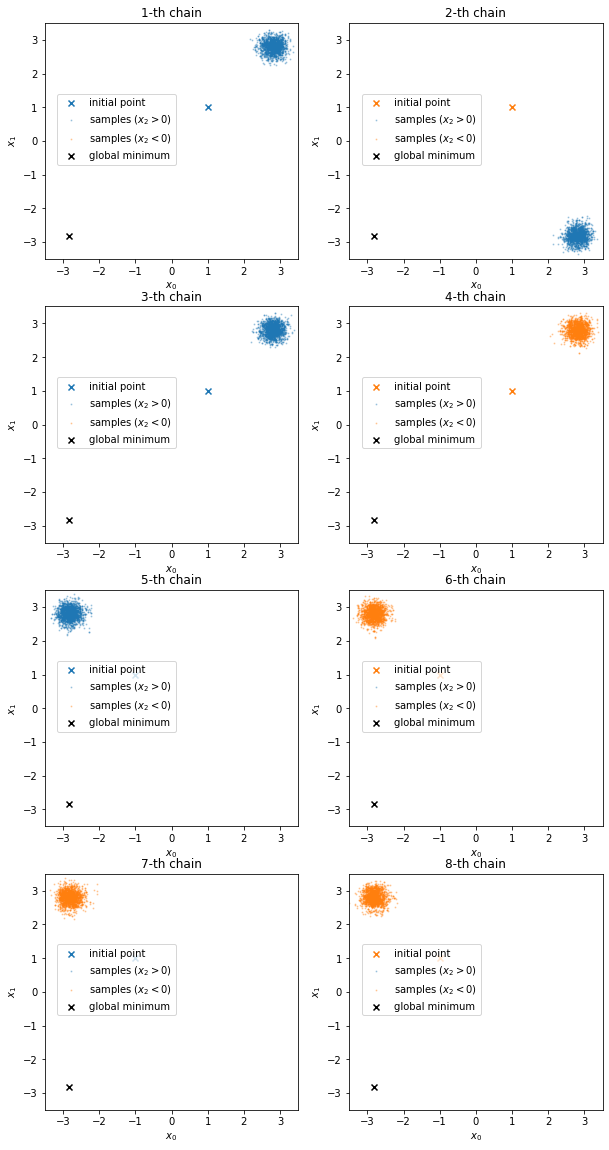

In [12]:
print("各chainのサンプリング結果(1,2次元目.3次元目は色で表示)")
lim=abs(sample_j_n_k_c[:,0,burnin::skip,:]).max()
fig, axes = plt.subplots(
    figsize=(5*2, 5*4),
    nrows=4, ncols=2,
    sharex=False)
for chain in range(n_chain):
    axes[chain//2, chain%2].scatter(
        [(-1)**(chain//4)],
        [(-1)**((chain//4)//2)],
        c=f"C{chain%2}",
        marker="x", label="initial point")
    axes[chain//2, chain%2].scatter(
        sample_j_n_k_c[chain, 0, burnin::skip, 0][sample_j_n_k_c[chain, 0, burnin::skip, 2]>0],
        sample_j_n_k_c[chain, 0, burnin::skip, 1][sample_j_n_k_c[chain, 0, burnin::skip, 2]>0],
        s=1, alpha=0.3, label=r"samples ($x_2>0$)"
    )
    axes[chain//2, chain%2].scatter(
        sample_j_n_k_c[chain, 0, burnin::skip, 0][sample_j_n_k_c[chain, 0, burnin::skip, 2]<0],
        sample_j_n_k_c[chain, 0, burnin::skip, 1][sample_j_n_k_c[chain, 0, burnin::skip, 2]<0],
        s=1, alpha=0.3, label=r"samples ($x_2<0$)"
    )
    axes[chain//2, chain%2].scatter([global_solution], [global_solution], c="k", marker="x", label="global minimum")
    axes[chain//2, chain%2].set_xlim(-lim, lim)
    axes[chain//2, chain%2].set_ylim(-lim, lim)
    axes[chain//2, chain%2].set_xlabel(r"$x_0$")
    axes[chain//2, chain%2].set_ylabel(r"$x_1$")
    axes[chain//2, chain%2].legend(loc=(0.05, 0.4))
    axes[chain//2, chain%2].set_title(f"{chain+1}-th chain")
plt.show()

各chainが特定の谷付近にトラップされて抜け出せておらず，片方ピークだけしかサンプリングできていない

## REMCMC

初期値は $(2.5, 2.5, 2.5)$ (一番遠い山)に取ってみる．

In [13]:
with open(glob.glob("test_remcmc_*.bin")[-1], mode="rb") as file:
    data = pickle.load(file)

sample_j_n_k = np.array(data["sample_j_n_k"])

k0 = abs(np.log10(data["beta_k"])).argmin()
burnin = 100
skip = 3

In [14]:
burnin = 1000
skip = 5

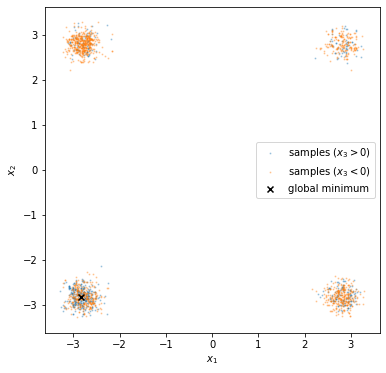

In [15]:
plt.figure(figsize=(6,6))
plt.scatter(
    sample_j_n_k[k0, burnin::skip, 0][sample_j_n_k[k0, burnin::skip, 2]>0],
    sample_j_n_k[k0, burnin::skip, 1][sample_j_n_k[k0, burnin::skip, 2]>0],
    s=1, alpha=0.3, label=r"samples ($x_3>0$)"
)
plt.scatter(
    sample_j_n_k[k0, burnin::skip, 0][sample_j_n_k[k0, burnin::skip, 2]<0],
    sample_j_n_k[k0, burnin::skip, 1][sample_j_n_k[k0, burnin::skip, 2]<0],
    s=1, alpha=0.3, label=r"samples ($x_3<0$)"
)
plt.scatter([global_solution], [global_solution], c="k", marker="x", label="global minimum")
lim = abs(np.array([*plt.xlim(), *plt.ylim()])).max()
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.legend()
plt.show()

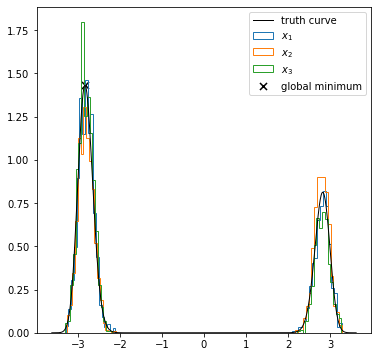

In [16]:
plt.figure(figsize=(6,6))
for d in range(3):
    plt.hist(
        sample_j_n_k[k0, burnin::skip, d],
        bins=100, density=True, histtype="step",
        label=f"$x_{d+1}$"
    )
plt.plot(
    np.linspace(-lim, lim, 1000),
    f(np.linspace(-lim, lim, 1000)),
    color="k", linewidth=1,
    label=f"truth curve"
)
plt.scatter(
    [global_solution], [f([global_solution])],
    c="k", marker="x", s=50,
    label="global minimum")
#plt.xlim(-4, 0)
plt.ylim(0, )
plt.legend()
plt.show()

In [17]:
print("左右のピークの面積比")
print("x_1<0 : x_1>0, x_2<0 : x_2>0, x_3<0 : x_3>0")
print(
    "{:.3f}".format((sample_j_n_k[k0, burnin::skip, 0]<0).mean()), ":",
    "{:.3f},".format((sample_j_n_k[k0, burnin::skip, 0]>0).mean()),
    "{:.3f}".format((sample_j_n_k[k0, burnin::skip, 1]<0).mean()), ":",
    "{:.3f},".format((sample_j_n_k[k0, burnin::skip, 1]>0).mean()),
    "{:.3f}".format((sample_j_n_k[k0, burnin::skip, 2]<0).mean()), ":",
    "{:.3f}".format((sample_j_n_k[k0, burnin::skip, 2]>0).mean()))

左右のピークの面積比
x_1<0 : x_1>0, x_2<0 : x_2>0, x_3<0 : x_3>0
0.642 : 0.358, 0.575 : 0.425, 0.689 : 0.311


遠い山から始めても正しいサンプリングができている．(x_2は少しずれているが)

$\beta$ による分布の変化

In [18]:
data["beta_k"]

array([1.00000000e-05, 3.16227766e-05, 1.00000000e-04, 3.16227766e-04,
       1.00000000e-03, 3.16227766e-03, 1.00000000e-02, 3.16227766e-02,
       1.00000000e-01, 3.16227766e-01, 1.00000000e+00, 3.16227766e+00,
       1.00000000e+01, 3.16227766e+01, 1.00000000e+02, 3.16227766e+02,
       1.00000000e+03, 3.16227766e+03, 1.00000000e+04, 3.16227766e+04,
       1.00000000e+05])

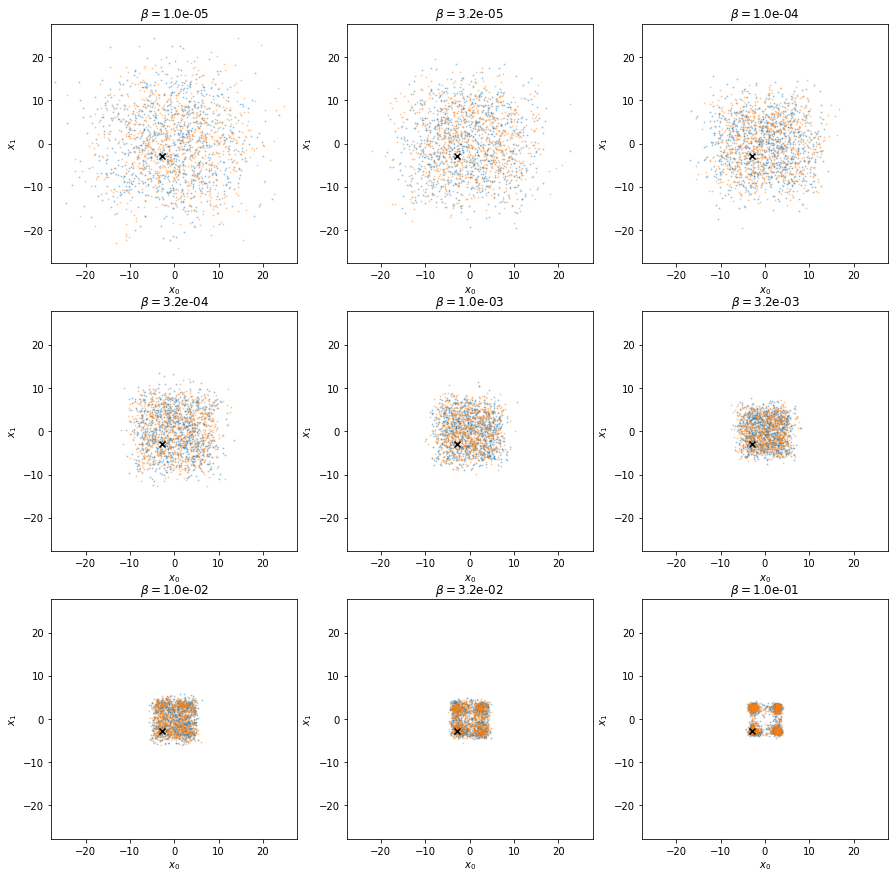

In [19]:
start, end = 0, 9
width = 3
height = -((- end + start)//width)
lim=abs(sample_j_n_k[0,burnin::skip,:]).max()
fig, axes = plt.subplots(
    figsize=(5*width, 5*height),
    nrows=height, ncols=width,
    sharex=False)
for k,beta in enumerate(data["beta_k"]):
    if k<start or k>=end: continue
    axes[(k-start)//width, k%width].scatter(
        sample_j_n_k[k, burnin::skip, 0][sample_j_n_k[k, burnin::skip, 2]>0],
        sample_j_n_k[k, burnin::skip, 1][sample_j_n_k[k, burnin::skip, 2]>0],
        s=1, alpha=0.3, label=r"samples ($x_2>0$)"
    )
    axes[(k-start)//width, k%width].scatter(
        sample_j_n_k[k, burnin::skip, 0][sample_j_n_k[k, burnin::skip, 2]<0],
        sample_j_n_k[k, burnin::skip, 1][sample_j_n_k[k, burnin::skip, 2]<0],
        s=1, alpha=0.3, label=r"samples ($x_2>0$)"
    )
    axes[(k-start)//width, k%width].scatter([global_solution], [global_solution], c="k", marker="x", label="global minimum")
    axes[(k-start)//width, k%width].set_xlim(-lim, lim)
    axes[(k-start)//width, k%width].set_ylim(-lim, lim)
    axes[(k-start)//width, k%width].set_xlabel(r"$x_0$")
    axes[(k-start)//width, k%width].set_ylabel(r"$x_1$")
    axes[(k-start)//width, k%width].set_title(r"$\beta=$"f"{beta:.1e}")
plt.show()

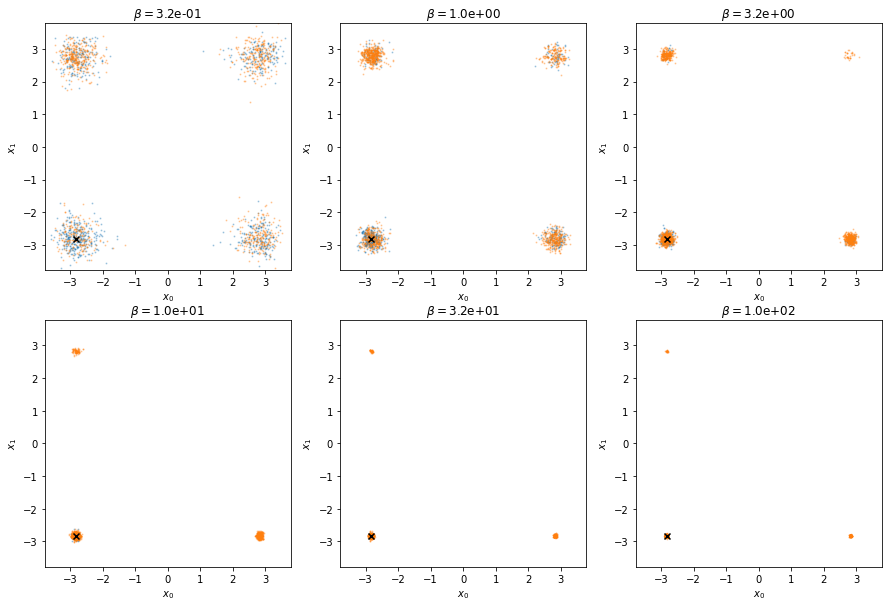

In [20]:
start, end = 9, 15
width = 3
height = -((- end + start)//width)
lim=abs(sample_j_n_k[start,burnin::skip,:]).max()
fig, axes = plt.subplots(
    figsize=(5*width, 5*height),
    nrows=height, ncols=width,
    sharex=False)
for k,beta in enumerate(data["beta_k"]):
    if k<start or k>=end: continue
    axes[(k-start)//width, k%width].scatter(
        sample_j_n_k[k, burnin::skip, 0][sample_j_n_k[k, burnin::skip, 2]>0],
        sample_j_n_k[k, burnin::skip, 1][sample_j_n_k[k, burnin::skip, 2]>0],
        s=1, alpha=0.3, label=r"samples ($x_2>0$)"
    )
    axes[(k-start)//width, k%width].scatter(
        sample_j_n_k[k, burnin::skip, 0][sample_j_n_k[k, burnin::skip, 2]<0],
        sample_j_n_k[k, burnin::skip, 1][sample_j_n_k[k, burnin::skip, 2]<0],
        s=1, alpha=0.3, label=r"samples ($x_2>0$)"
    )
    axes[(k-start)//width, k%width].scatter([global_solution], [global_solution], c="k", marker="x", label="global minimum")
    axes[(k-start)//width, k%width].set_xlim(-lim, lim)
    axes[(k-start)//width, k%width].set_ylim(-lim, lim)
    axes[(k-start)//width, k%width].set_xlabel(r"$x_0$")
    axes[(k-start)//width, k%width].set_ylabel(r"$x_1$")
    axes[(k-start)//width, k%width].set_title(r"$\beta=$"f"{beta:.1e}")
plt.show()

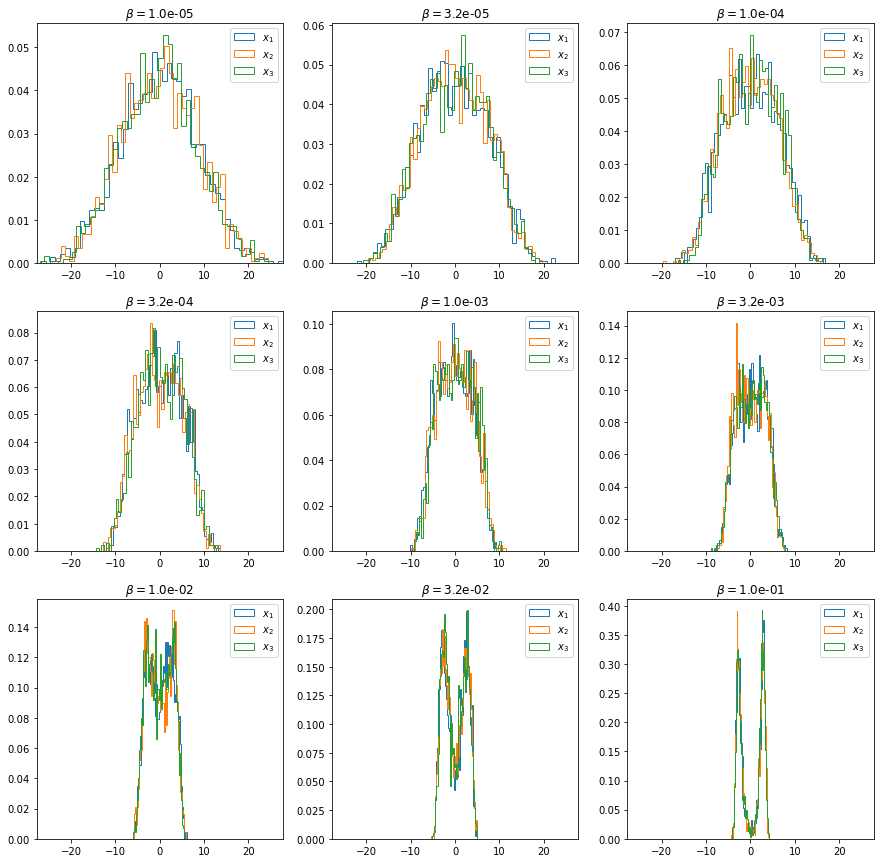

In [21]:
start, end = 0, 9
width = 3
height = -((- end + start)//width)
lim=abs(sample_j_n_k[0,burnin::skip,:]).max()
fig, axes = plt.subplots(
    figsize=(5*width, 5*height),
    nrows=height, ncols=width,
    sharex=False)
for k,beta in enumerate(data["beta_k"]):
    if k<start or k>=end: continue
    for d in range(3):
        axes[(k-start)//width, k%width].hist(
            sample_j_n_k[k, burnin::skip, d],
           bins=50, density=True, histtype="step",
            label=f"$x_{d+1}$"
        )
    if k==k0:
        axes[(k-start)//width, k%width].plot(
            np.linspace(-lim, lim, 1000),
            f(np.linspace(-lim, lim, 1000)),
            color="k",
            label=f"truth curve"
        )
    axes[(k-start)//width, k%width].set_xlim(-lim, lim)
    axes[(k-start)//width, k%width].set_ylim(0, )
    axes[(k-start)//width, k%width].legend(loc="upper right")
    axes[(k-start)//width, k%width].set_title(r"$\beta=$"f"{beta:.1e}")
plt.show()

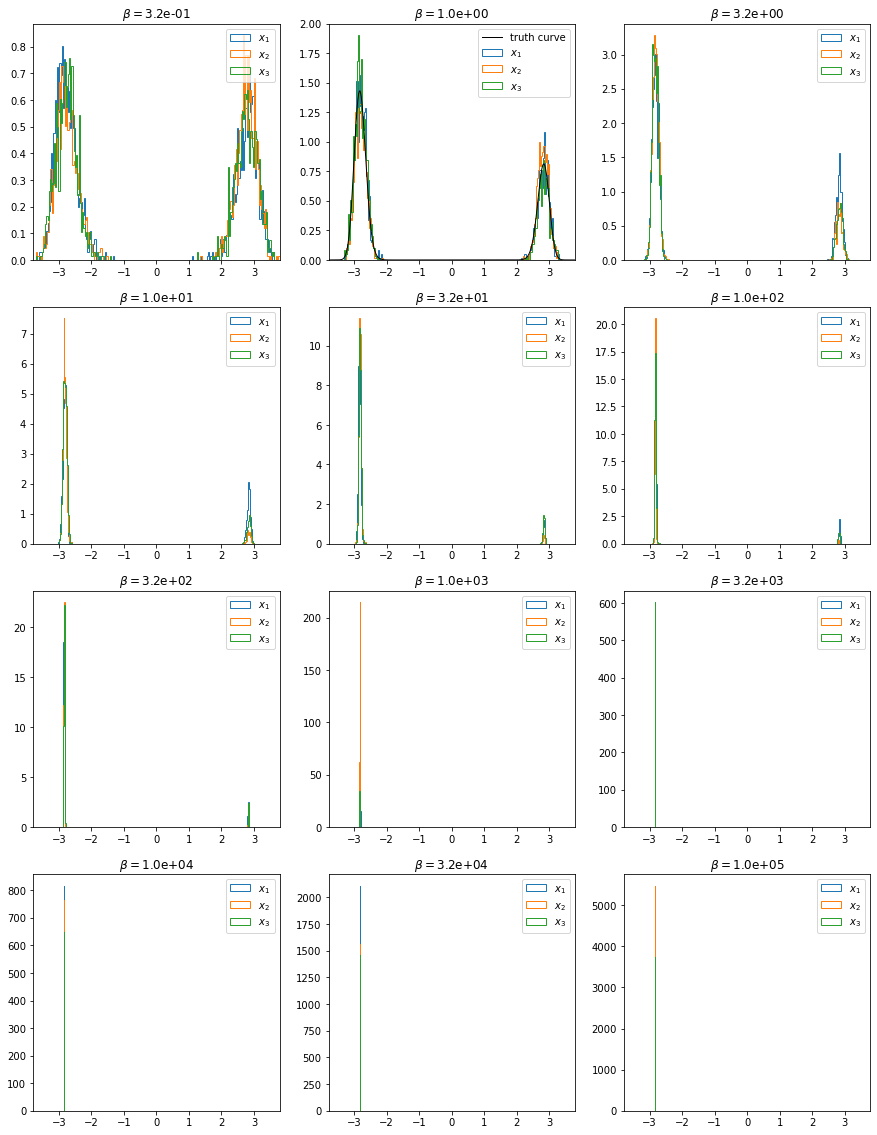

In [22]:
start, end = 9, 21
width = 3
height = -((- end + start)//width)
lim=abs(sample_j_n_k[9, burnin::skip,:]).max()
fig, axes = plt.subplots(
    figsize=(5*width, 5*height),
    nrows=height, ncols=width,
    sharex=False)
for k,beta in enumerate(data["beta_k"]):
    if k<start or k>=end: continue
    for d in range(3):
        axes[(k-start)//width, k%width].hist(
            sample_j_n_k[k, burnin::skip, d],
            bins=200, density=True, histtype="step",
            label=f"$x_{d+1}$"
        )
    if k==k0:
        axes[(k-start)//width, k%width].plot(
            np.linspace(-lim, lim, 1000),
            f(np.linspace(-lim, lim, 1000)),
            color="k", linewidth=1,
            label=f"truth curve"
        )
    axes[(k-start)//width, k%width].set_xlim(-lim, lim)
    axes[(k-start)//width, k%width].set_ylim(0, )
    axes[(k-start)//width, k%width].legend(loc="upper right")
    axes[(k-start)//width, k%width].set_title(r"$\beta=$"f"{beta:.1e}")
plt.show()

$\beta=0.1$ くらいのところでは $x<0, x>0$ 両方をとるなめらかな分布となっている  
$\beta=10^5$ ではほぼ大域解に集中している(≒最尤推定値)

In [23]:
print("真の大域解とβ=10^5でのMAP推定値の比較")
print("真の解:", f"{global_solution:.4f}")
print("MAP estimation of")
for d in range(3):
    print(f"  x_{d+1}:",
          f"{sample_j_n_k[-1,burnin::skip,d].mean():.4f}"\
          f"±{sample_j_n_k[-1,burnin::skip,d].std():.4f}")

真の大域解とβ=10^5でのMAP推定値の比較
真の解: -2.8316
MAP estimation of
  x_1: -2.8317±0.0006
  x_2: -2.8315±0.0005
  x_3: -2.8316±0.0005
